**Script Description:** This script loads a pre-processed dataset, computes the pearson correlation coefficient of the features and predictors. The feature importances embedded in XGBoost are also computed.

**File Name:** 02_02_Feature_Selec_Corr_Embedded.ipynb

**Date:** 2025

**Created by:** Rob Alamgir  

#### Import the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.exceptions import FitFailedWarning
from xgboost.sklearn import XGBRegressor

### Step 1: Load and preprocess dataset, compute the Pearson and Spearman correlation

In [2]:
# Load and preprocess data
data_path = "C:/Data_MSc_Thesis/Pre_Processed_Data_Final/Pre_Processed_Data_All_Locations_V6.csv"
complete_dataset = pd.read_csv(data_path, low_memory=False)

column_to_remove = 'Porosity'  
complete_dataset = complete_dataset.drop(columns=[column_to_remove])
#complete_dataset.info(verbose=True)

In [3]:
rename_dict = {
    "Porosity_BIS4D_SOM": "Porosity",
    "BOFEK_2020_Physical Units": "BOFEK_PU",
    "Peat_Thickness_2022": "Peat_Thickness"
}
complete_dataset.rename(columns=rename_dict, inplace=True)
#complete_dataset.info(verbose=True)

complete_dataset['Date'] = pd.to_datetime(complete_dataset['Date']) 
complete_dataset['Source_ID'] = complete_dataset['Site_ID'].astype('category').cat.codes + 1 

filtered_df = complete_dataset.dropna(subset=['SENTEK_SMC']).copy()
filtered_df['BOFEK_PU'] = filtered_df['BOFEK_PU'].astype('category')

vars_to_correlate = ["SENTEK_SMC", "Sentinel_1_SMC", "Planet_SMC", "S1_Backscatter","S1_Backscatter_SD", "S2_NDVI", "S2_EVI", "S2_NDMI", "L8_9_LST", "MODIS_LAI",
                     "STMP_1_015", "ATMP_f", "PAIR_f", "WTMP_f", "WLEV_f", "WIND_f", "WINS_f", "RHUM_f", "RAIN_f", "VPD_f", "ET", "PET", "ET0",  
                     "RZSM_OWASIS", "GWL_OWASIS", "AWS_OWASIS", "BD_5_15", "Clay_5_15", "Sand_5_15", "Silt_5_15", "SOM_2023_5_15", "Porosity", "BOFEK_PU", "Peat_Thickness"]

Cor_filtered_df = complete_dataset.dropna(subset=['SENTEK_SMC']).copy()
all_variables_df = Cor_filtered_df[vars_to_correlate].copy()
pearson_cor_results = all_variables_df.corr(method='pearson')
spearman_cor_results = all_variables_df.corr(method='spearman')

In [4]:
cor_with_target = pearson_cor_results['SENTEK_SMC']

# Define the correlation threshold range (for weak correlation)
lower_threshold = -0.1
upper_threshold = 0.1

# Filter features that have a correlation between -0.2 and 0.2 with 'SENTEK_SMC'
weak_correlation_features = cor_with_target[(cor_with_target > lower_threshold) & (cor_with_target < upper_threshold)]

print("Features with weak or no correlation with 'SENTEK_SMC' (between -0.1 and 0.1):")
print(weak_correlation_features)

Features with weak or no correlation with 'SENTEK_SMC' (between -0.1 and 0.1):
S1_Backscatter_SD   -0.064495
S2_NDVI             -0.029242
S2_EVI              -0.098254
PAIR_f              -0.054126
WIND_f               0.008376
RAIN_f              -0.003977
ET                  -0.011050
AWS_OWASIS           0.003237
BD_5_15              0.050936
Clay_5_15           -0.022090
Sand_5_15           -0.001156
Silt_5_15            0.085225
SOM_2023_5_15        0.029765
BOFEK_PU             0.052115
Name: SENTEK_SMC, dtype: float64


In [5]:
features_only = [col for col in vars_to_correlate if col != "SENTEK_SMC"] # List of variables (excluding the target)
feature_df = Cor_filtered_df[features_only].copy()                        # Subset the DataFrame

corr_matrix = feature_df.corr(method='pearson').abs()    # Compute correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_threshold = 0.8    # Define correlation threshold for potential multicollinearity

# Find feature pairs with high correlation
highly_correlated_pairs = upper_triangle.stack().reset_index()
highly_correlated_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs['Correlation'] > high_corr_threshold]

print("Highly correlated feature pairs (|correlation| > 0.8):")
print(highly_correlated_pairs.sort_values(by='Correlation', ascending=False))

Highly correlated feature pairs (|correlation| > 0.8):
      Feature_1       Feature_2  Correlation
450         PET             ET0     0.988242
509   Clay_5_15   SOM_2023_5_15     0.986898
514   Sand_5_15   SOM_2023_5_15     0.970245
507   Clay_5_15       Sand_5_15     0.962842
525    Porosity        BOFEK_PU     0.942186
122     S2_NDVI          S2_EVI     0.931675
526    Porosity  Peat_Thickness     0.928149
527    BOFEK_PU  Peat_Thickness     0.923646
252  STMP_1_015          ATMP_f     0.920173
205    L8_9_LST          ATMP_f     0.899689
505     BD_5_15        BOFEK_PU     0.874421
521   Silt_5_15  Peat_Thickness     0.867246
204    L8_9_LST      STMP_1_015     0.858520
215    L8_9_LST             PET     0.856620
39   Planet_SMC      STMP_1_015     0.845548
37   Planet_SMC        L8_9_LST     0.844192
506     BD_5_15  Peat_Thickness     0.831646
519   Silt_5_15        Porosity     0.812295


In [ ]:
#filtered_df.info(verbose=True)
#all_variables_df.info(verbose=True)
#pearson_cor_results.info(verbose=True)
#spearman_cor_results.info(verbose=True)

### Step 2: Plot Correlation Matrices

#### 1. Pearson Correlation Matrix

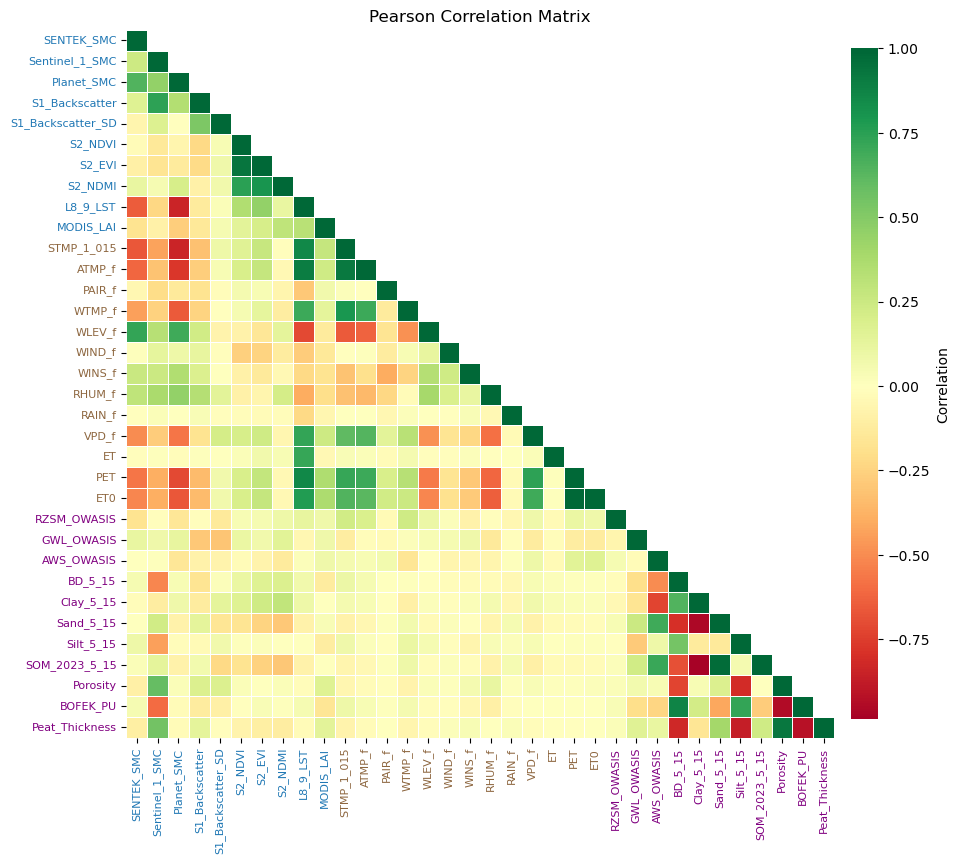

In [6]:
plt.figure(figsize=(11, 13))  
mask = np.triu(np.ones_like(pearson_cor_results, dtype=bool), k=1)  # Mask upper triangle

ax = sns.heatmap(pearson_cor_results, mask=mask, annot=False, cmap="RdYlGn",
            center=0, linewidths=0.5, fmt=".2f",
            annot_kws={'size': 8},  
            cbar_kws={'label': 'Correlation', 'shrink': 0.67, 'aspect': 25, 'pad': 0.02}, 
            square=True)

plt.title('Pearson Correlation Matrix', fontsize=12)
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().tick_params(axis='x', bottom=True, top=False, labelsize=8)
plt.gca().tick_params(axis='y', right=False, labelsize=8)
plt.gca().yaxis.set_ticks_position('left')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

labels = plt.gca().get_xticklabels() + plt.gca().get_yticklabels()
blue_labels = ["SENTEK_SMC", "Sentinel_1_SMC", "Planet_SMC", "S1_Backscatter","S1_Backscatter_SD", "S2_NDVI", "S2_EVI", "S2_NDMI", "L8_9_LST", "MODIS_LAI"]
brown_labels = ["STMP_1_015", "ATMP_f", "PAIR_f", "WTMP_f", "WLEV_f", "WIND_f", "WINS_f", "RHUM_f", "RAIN_f", "VPD_f", "ET", "PET", "ET0"]
purple_labels = ["RZSM_OWASIS", "GWL_OWASIS", "AWS_OWASIS", "BD_5_15", "Clay_5_15", "Sand_5_15", "Silt_5_15", "SOM_2023_5_15", "Porosity", "BOFEK_PU", "Peat_Thickness"]

for label in labels:
    if label.get_text() in blue_labels:
        label.set_color('#1f77b4')  
    elif label.get_text() in brown_labels:
        label.set_color('#8D663F')  
    elif label.get_text() in purple_labels:
        label.set_color('purple')    

#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/PCC_Matrix_RQ1.png"  
#ax.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

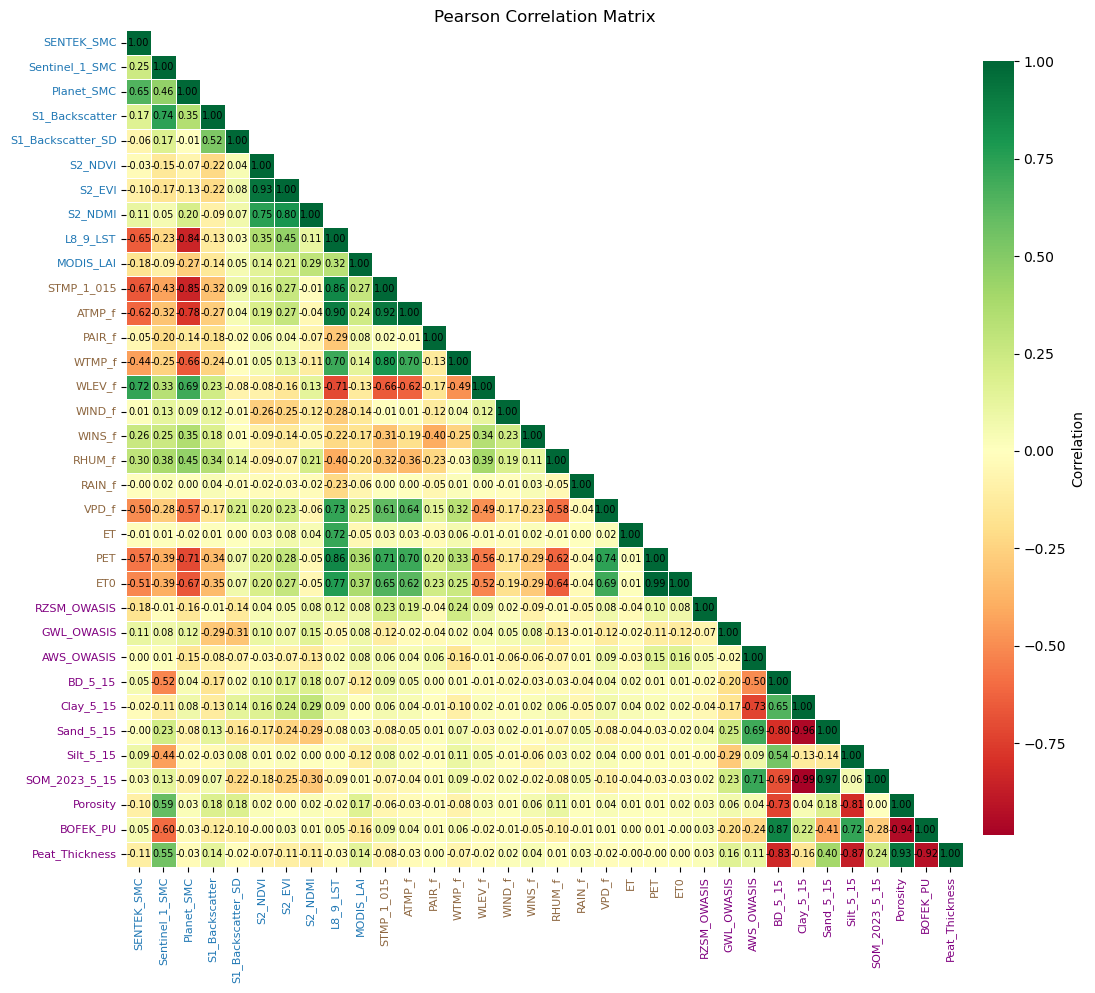

In [7]:
plt.figure(figsize=(13, 15))  
mask = np.triu(np.ones_like(pearson_cor_results, dtype=bool), k=1)  # Mask upper triangle

ax = sns.heatmap(
    pearson_cor_results,
    mask=mask,
    annot=True,  # <-- Show correlation values
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    fmt=".2f",
    annot_kws={'size': 7, 'color': 'black'},  # <-- Text style
    cbar_kws={'label': 'Correlation', 'shrink': 0.67, 'aspect': 25, 'pad': 0.02}, 
    square=True
)

plt.title('Pearson Correlation Matrix', fontsize=12)
plt.gca().xaxis.set_ticks_position('bottom')
plt.gca().tick_params(axis='x', bottom=True, top=False, labelsize=8)
plt.gca().tick_params(axis='y', right=False, labelsize=8)
plt.gca().yaxis.set_ticks_position('left')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

labels = plt.gca().get_xticklabels() + plt.gca().get_yticklabels()
blue_labels = ["SENTEK_SMC", "Sentinel_1_SMC", "Planet_SMC", "S1_Backscatter","S1_Backscatter_SD", "S2_NDVI", "S2_EVI", "S2_NDMI", "L8_9_LST", "MODIS_LAI"]
brown_labels = ["STMP_1_015", "ATMP_f", "PAIR_f", "WTMP_f", "WLEV_f", "WIND_f", "WINS_f", "RHUM_f", "RAIN_f", "VPD_f", "ET", "PET", "ET0"]
purple_labels = ["RZSM_OWASIS", "GWL_OWASIS", "AWS_OWASIS", "BD_5_15", "Clay_5_15", "Sand_5_15", "Silt_5_15", "SOM_2023_5_15", "Porosity", "BOFEK_PU", "Peat_Thickness"]

for label in labels:
    if label.get_text() in blue_labels:
        label.set_color('#1f77b4')  
    elif label.get_text() in brown_labels:
        label.set_color('#8D663F')  
    elif label.get_text() in purple_labels:
        label.set_color('purple')    

#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/PCC_Matrix_RQ1_Num.png"  
#ax.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

### Step 3: Plot bar graphs

#### Pearson corelation between features and predictor

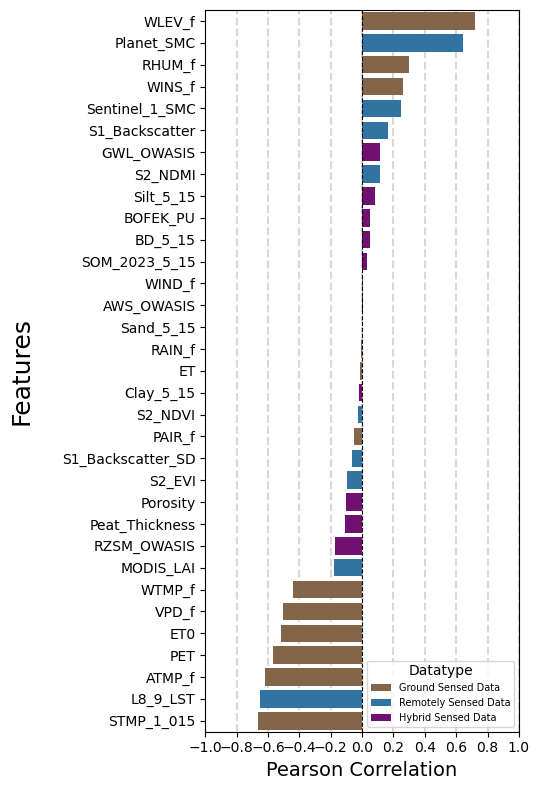

In [9]:
categories = {"Remotely Sensed Data": ["SENTEK_SMC", "Sentinel_1_SMC", "Planet_SMC", "S1_Backscatter","S1_Backscatter_SD", "S2_NDVI", "S2_EVI", "S2_NDMI", "L8_9_LST", "MODIS_LAI"],
              "Hybrid Sensed Data": ["RZSM_OWASIS", "GWL_OWASIS", "AWS_OWASIS", "BD_5_15", "Clay_5_15", "Sand_5_15", "Silt_5_15", "SOM_2023_5_15", "Porosity", "BOFEK_PU", "Peat_Thickness"],
              "Ground Sensed Data": ["STMP_1_015", "ATMP_f", "PAIR_f", "WTMP_f", "WLEV_f", "WIND_f", "WINS_f", "RHUM_f", "RAIN_f", "VPD_f", "ET", "PET", "ET0"]
             }

target_variable = "SENTEK_SMC"
correlation_data = []

for category, vars_in_category in categories.items():
    for variable in vars_in_category:
        if variable != target_variable:
            if target_variable in pearson_cor_results.index and variable in pearson_cor_results.columns:
                correlation = pearson_cor_results.loc[target_variable, variable]
                correlation_data.append({
                    "Feature": variable,
                    "Correlation": correlation,
                    "Datatype": category
                })

pearson_cor_results_flat = pd.DataFrame(correlation_data)
pearson_cor_results_flat['Correlation'] = pd.to_numeric(pearson_cor_results_flat['Correlation'], errors='coerce')
pearson_cor_results_flat = pearson_cor_results_flat.sort_values('Correlation', ascending=False)

# Create figure
fig1, ax = plt.subplots(figsize=(5.5, 8))
sns.barplot(
    data=pearson_cor_results_flat,
    x="Correlation", y="Feature", hue="Datatype", dodge=False,
    palette={
        "Remotely Sensed Data": "#1f77b4",
        "Hybrid Sensed Data": "purple",
        "Ground Sensed Data": "#8D663F"
    },
    width=0.8,
    ax=ax
)

xtick_positions = np.arange(-1.0, 1.05, 0.2)
ax.set_xticks(xtick_positions)

for tick in xtick_positions:
    ax.axvline(x=tick, linestyle="--", color="gray", alpha=0.3, zorder=0)

ax.axvline(0, color='black', linestyle='--', linewidth=0.8, zorder=1)
ax.set_xlabel("Pearson Correlation", fontsize=14)
ax.set_ylabel("Features", fontsize=18, labelpad=20)
ax.legend(title="Datatype", loc='lower right', fontsize=7)
plt.tight_layout()
#plt.title("Feature Correlations with SENTEK_SMC", fontsize=16)

#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/PCC_Bar_Plot_1.png"  
#fig1.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

### Step 4: Compute Embedded Feature importance

In [10]:
RS_GSD_Features = ["Sentinel_1_SMC", "S1_Backscatter","S1_Backscatter_SD", "S2_NDVI", "S2_EVI", "S2_NDMI", "L8_9_LST", "MODIS_LAI",
                   "STMP_1_015", "ATMP_f", "PAIR_f", "WTMP_f", "WLEV_f", "WIND_f", "WINS_f", "RHUM_f", "RAIN_f", "VPD_f", "ET", "PET", "ET0", 
                   "RZSM_OWASIS", "GWL_OWASIS", "AWS_OWASIS", "BD_5_15", "Clay_5_15", "Sand_5_15", "Silt_5_15", "SOM_2023_5_15", "Porosity", "BOFEK_PU", "Peat_Thickness","DOY"]

X = filtered_df[RS_GSD_Features]    # Features   
y = filtered_df['SENTEK_SMC']       # Predictor
groups = filtered_df["Source_ID"]   # Groups for Leave-One-Group-Out
dates = filtered_df['Date']

# Function to calculate feature importance
def xgboost_fi(X, y):
    model = XGBRegressor(n_estimators=800,
                         max_depth=6,
                         learning_rate=0.1,
                         subsample=0.5,
                         colsample_bytree = 0.5,
                         random_state=42,
                         enable_categorical=True)
    model.fit(X, y)
    feat_imps = dict(zip(X.columns, model.feature_importances_))  # Feature importances embedded in the model
    return {k: v for k, v in sorted(feat_imps.items(), key=lambda item: item[1], reverse=True)} # Return sorted feature importances

feature_importances = xgboost_fi(X, y)
#print("Feature Importances:")
#for feature, importance in feature_importances.items():
#    print(f"{feature}: {importance}")

# Convert the feature importances to a DataFrame
results = pd.DataFrame({'Features': list(feature_importances.keys()),
                        'Importance': list(feature_importances.values())})

feature_categories = {"Remotely Sensed Data": ["SENTEK_SMC", "Sentinel_1_SMC", "Planet_SMC", "S1_Backscatter","S1_Backscatter_SD", "S2_NDVI", "S2_EVI", "S2_NDMI", "L8_9_LST", "MODIS_LAI"],
                      "Hybrid Sensed Data": ["RZSM_OWASIS", "GWL_OWASIS", "AWS_OWASIS", "BD_5_15", "Clay_5_15", "Sand_5_15", "Silt_5_15", "SOM_2023_5_15", "Porosity", "BOFEK_PU", "Peat_Thickness"],
                      "Ground Sensed Data": ["STMP_1_015", "ATMP_f", "PAIR_f", "WTMP_f", "WLEV_f", "WIND_f", "WINS_f", "RHUM_f", "RAIN_f", "VPD_f", "ET", "PET", "ET0"]
                     }

# Create a function to assign categories
def assign_categories(feature, category_dict):
    assigned_categories = [category for category, features in category_dict.items() if feature in features]
    return ", ".join(assigned_categories) if assigned_categories else "Uncategorized"

# Add category columns to the DataFrame
results['Categories'] = results['Features'].apply(lambda x: assign_categories(x, feature_categories))
results['Feature Categories'] = results['Features'].apply(lambda x: assign_categories(x, feature_categories))

#print(results) # Display the updated DataFrame

category_colors = {
    "Remotely Sensed Data": "#1f77b4",
    "Ground Sensed Data": "#8D663F",
    "Hybrid Sensed Data": "purple"}

category_colors["Uncategorized"] = "gray"   # Add a default color for 'Uncategorized'

# Map categories to the hue variable for coloring
results['Hue'] = results['Categories'].apply(lambda x: x.split(", ")[0] if isinstance(x, str) else "Uncategorized")
results = results.sort_values(by='Importance', ascending=False)

#### Plot Embedded Feature importance

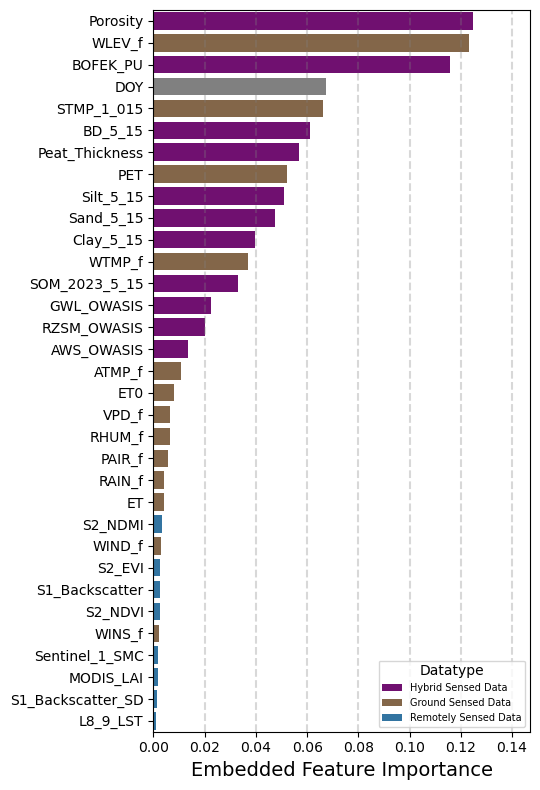

In [11]:
fig2 = plt.figure(figsize=(5.5, 8))
ax1 = sns.barplot(data=results, x='Importance', y='Features',
                  hue='Hue', dodge=False, palette=category_colors, width=0.8)

xticks = plt.xticks()[0]
for tick in xticks:
    plt.axvline(x=tick, linestyle="--", color="gray", alpha=0.3)

plt.xlabel("Embedded Feature Importance", fontsize=14)
plt.ylabel("", fontsize=14)

# Remove 'Uncategorized' from the legend only
handles, labels = ax1.get_legend_handles_labels()
new_handles = []
new_labels = []
for h, l in zip(handles, labels):
    if l != 'Uncategorized':
        new_handles.append(h)
        new_labels.append(l)

# Only show updated legend if any labels remain
if new_labels:
    ax1.legend(handles=new_handles, labels=new_labels, title="Datatype", loc='lower right', fontsize=7)
else:
    ax1.legend_.remove()

plt.tight_layout()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Emb_Feat_Selec_Plot_1.png"  
#ax1.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()

Figure saved successfully at: C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Comb_Emb_Feat_Selec_Plot.png


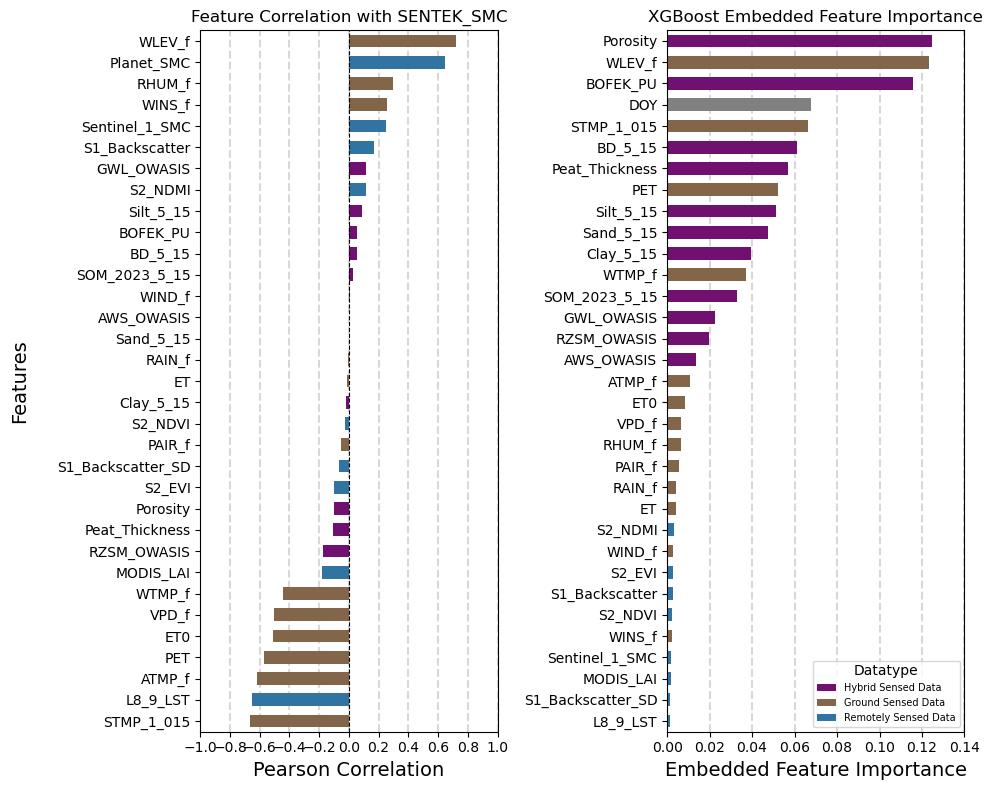

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8), sharey=False)

sns.barplot(
    data=pearson_cor_results_flat,
    x="Correlation", y="Feature", hue="Datatype", dodge=False,
    palette={"Remotely Sensed Data": "#1f77b4", "Hybrid Sensed Data": "purple", "Ground Sensed Data": "#8D663F"},
    width=0.6, ax=ax1
)

ax1_xticks = np.arange(-1.0, 1.05, 0.2)
ax1.set_xticks(ax1_xticks)
for tick in ax1_xticks:
    ax1.axvline(x=tick, linestyle="--", color="gray", alpha=0.3, zorder=0)

ax1.axvline(0, color='black', linestyle='--', linewidth=0.8, zorder=1)
ax1.set_xlabel("Pearson Correlation", fontsize=14)
ax1.set_ylabel("Features", fontsize=14, labelpad=20)
ax1.set_title("Feature Correlation with SENTEK_SMC", fontsize=12)
ax1.get_legend().remove()

sns.barplot(data=results, x='Importance', y='Features', hue='Hue',
            dodge=False, palette=category_colors, width=0.6, ax=ax2)

ax2_xticks = np.arange(0, 0.16, 0.02)
ax2.set_xticks(ax2_xticks)
for tick in ax2_xticks:
    ax2.axvline(x=tick, linestyle="--", color="gray", alpha=0.3, zorder=0)

ax2.set_xlabel("Embedded Feature Importance", fontsize=14)
ax2.set_ylabel("")  
ax2.set_title("XGBoost Embedded Feature Importance", fontsize=12)

handles, labels = ax2.get_legend_handles_labels()
filtered = [(h, l) for h, l in zip(handles, labels) if l != 'Uncategorized']
if filtered:
    f_handles, f_labels = zip(*filtered)
    ax2.legend(handles=f_handles, labels=f_labels, title="Datatype", loc='lower right', fontsize=7)
else:
    ax2.legend_.remove()

plt.tight_layout()
#save_path = "C:/Users/robdu/OneDrive - Radboud Universiteit/Master Thesis/Infographics and Graphics/Figures/Comb_Emb_Feat_Selec_Plot.png"  
#ax1.figure.savefig(save_path, dpi=600, bbox_inches='tight')
#print(f"Figure saved successfully at: {save_path}")
plt.show()